Deep Neural Network

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler


import torch
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.nn as nn
# from utils.helper import fn_plot_tf_hist

In [ ]:
def fn_plot_torch_hist(hist_df):

    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

    # columns
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]

    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()]
    best = best.drop_duplicates(subset='test_loss')
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1, y2], ax = ax)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y2].min())
    y_max = max(hist_df[y1].max(), hist_df[y2].max())
    offset = (y_max-y_min)/10.0

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()+ offset, best[y2].to_numpy()[0]+offset), # location of text
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel(x.title())
    ax.set_ylabel(y1.title())
    ax.set_title('Errors')
    ax.grid(True)
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y3],
                           hist_df.iloc[-1][y4]) #text to plot

    # calculate offset for arroe
    y_min = min(hist_df[y3].min(), hist_df[y4].min())
    y_max = max(hist_df[y3].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()- offset, best[y4].to_numpy()[0]-offset), # location of text
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow


    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(),
               color = 'green',
               linestyle='-.', lw = 3)

    # Labels
    ax.set_xlabel(x.title())
    ax.set_ylabel(y3.title())
    ax.set_title('Accuracies')
    ax.grid(True)
    ax.legend(loc = 'lower left')

    plt.tight_layout()


In [ ]:
### ----------------------
### global variables
### ----------------------


import random

RANDOM_STATE = 24
np.random.RandomState(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)


TEST_SIZE = 3811
ALPHA = 0.001 # LEARNING RATE
EPOCHS = 2001  # NUMBER OF ITERATIONS
BATCH_SIZE = 256

PATIENCE = 20
LR_FACTOR = 0.1
LR_PATIENCE = 10


# input and output directories
inpDir = '../../input'
outDir = '../output'

params = {
    'legend.fontsize': 'medium',
    'figure.figsize': (10, 6),
    'axes.labelsize': 'medium',
    'axes.titlesize':'large',
    'xtick.labelsize':'medium',
    'ytick.labelsize':'medium'
}

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')

# Load Data

In [ ]:
data_df = pd.read_csv("fifa_2019.csv")
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


# EDA
1. Remove Null from Position
2. Read unique values from the columns

In [ ]:
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [ ]:
data_df.shape

(18147, 89)

In [ ]:
for col in data_df.columns:
    unq = data_df[col].unique()
    print(f'{col}, # : {len(unq)}, Values: {unq}')

Unnamed: 0, # : 18147, Values: [    0     1     2 ... 18204 18205 18206]
ID, # : 18147, Values: [158023  20801 190871 ... 241638 246268 246269]
Name, # : 17140, Values: ['L. Messi' 'Cristiano Ronaldo' 'Neymar Jr' ... 'B. Worman'
 'D. Walker-Rice' 'G. Nugent']
Age, # : 29, Values: [31 33 26 27 32 25 29 28 24 30 19 40 22 23 34 35 36 37 21 18 20 39 41 17
 38 45 42 16 44]
Photo, # : 18147, Values: ['https://cdn.sofifa.org/players/4/19/158023.png'
 'https://cdn.sofifa.org/players/4/19/20801.png'
 'https://cdn.sofifa.org/players/4/19/190871.png' ...
 'https://cdn.sofifa.org/players/4/19/241638.png'
 'https://cdn.sofifa.org/players/4/19/246268.png'
 'https://cdn.sofifa.org/players/4/19/246269.png']
Nationality, # : 164, Values: ['Argentina' 'Portugal' 'Brazil' 'Spain' 'Belgium' 'Croatia' 'Uruguay'
 'Slovenia' 'Poland' 'Germany' 'France' 'England' 'Italy' 'Egypt'
 'Colombia' 'Denmark' 'Gabon' 'Wales' 'Senegal' 'Costa Rica' 'Slovakia'
 'Netherlands' 'Bosnia Herzegovina' 'Morocco' 'Serbia' 'Alge

In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18147 entries, 0 to 18206
Data columns (total 89 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                18147 non-null  int64  
 1   ID                        18147 non-null  int64  
 2   Name                      18147 non-null  object 
 3   Age                       18147 non-null  int64  
 4   Photo                     18147 non-null  object 
 5   Nationality               18147 non-null  object 
 6   Flag                      18147 non-null  object 
 7   Overall                   18147 non-null  int64  
 8   Potential                 18147 non-null  int64  
 9   Club                      17918 non-null  object 
 10  Club Logo                 18147 non-null  object 
 11  Value                     18147 non-null  object 
 12  Wage                      18147 non-null  object 
 13  Special                   18147 non-null  int64  
 14  Preferred F

In [ ]:
rel_cols = ['Position', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
            'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning',
            'GKReflexes']

data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,RF,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,ST,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,LW,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,GK,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,RCM,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [ ]:
data_df.isna().sum().sum()

0

In [ ]:
data_df['Position'].unique()

array(['RF', 'ST', 'LW', 'GK', 'RCM', 'LF', 'RS', 'RCB', 'LCM', 'CB',
       'LDM', 'CAM', 'CDM', 'LS', 'LCB', 'RM', 'LAM', 'LM', 'LB', 'RDM',
       'RW', 'CM', 'RB', 'RAM', 'CF', 'RWB', 'LWB'], dtype=object)

In [ ]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS', 'LS', 'CF']
midfielder = ['CM', 'RCM', 'LCM', 'CDM', 'RDM', 'LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [ ]:
data_df.loc[data_df['Position'] == 'GK', 'Position'] = 0
data_df.loc[data_df['Position'].isin(defender), 'Position'] = 1
data_df.loc[data_df['Position'].isin(midfielder), 'Position'] = 2
data_df.loc[data_df['Position'].isin(forward), 'Position'] = 3
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast = 'integer')

In [ ]:
data_df['Position'].unique()

array([3, 0, 2, 1], dtype=int8)

In [ ]:
class_labels = {0 : 'Goalkeeper', 1 : 'Defender', 2 : 'Midfielder', 3 : 'Forward'}

In [ ]:
x = data_df.drop('Position', axis = 1)
y = data_df['Position'].to_numpy()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    random_state = RANDOM_STATE,
                                                    stratify = y,
                                                    test_size = TEST_SIZE)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((14336, 33), (3811, 33), (14336,), (3811,))

In [ ]:
type(x_train), type(x_test), type(y_train), type(y_test)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 numpy.ndarray,
 numpy.ndarray)

In [ ]:
sc = StandardScaler()

x_train = sc.fit_transform(x_train, y_train)
x_test = sc.transform(x_test)

# Define Custom Dataset

In [ ]:
class FifaDataset(Dataset):
    def __init__(self, x, y):
        super(FifaDataset, self).__init__()
        self.x = torch.tensor(x, dtype = torch.float32)
        self.y = torch.tensor(y, dtype = torch.long)

    def __len__(self):
        return(len(self.x))

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [ ]:
train_dataset = FifaDataset(x_train, y_train)
train_loader = DataLoader(dataset = train_dataset,
                          shuffle = True,
                          batch_size = BATCH_SIZE)

x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([256, 33]), torch.Size([256]))

In [ ]:
test_dataset = FifaDataset(x_test, y_test)
test_loader = DataLoader(dataset = test_dataset,
                          shuffle = True,
                          batch_size = BATCH_SIZE)

x_batch, y_batch = next(iter(test_loader))
x_batch.shape, y_batch.shape

(torch.Size([256, 33]), torch.Size([256]))

In [ ]:
torch.cuda.is_available()

True

In [ ]:
import torch.version

torch.version.cuda

'12.1'

In [ ]:
torch.cuda.get_device_name(torch.cuda.current_device())

'Tesla T4'

In [ ]:
device = 'cuda'

In [ ]:
x_train.shape, x_test.shape

((14336, 33), (3811, 33))

In [ ]:
input_dim = x_train.shape[1]

class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim,18)
        self.actv1 = nn.ReLU()
        self.layer2 = nn.Linear(18, 4)

    def forward(self, x):
        x = self.layer1(x)
        x = self.actv1(x)
        x = self.layer2(x)
        return x

model = Model(input_dim).to(device = device)

print(model)

# model = nn.keras.Sequential([
#     tf.keras.Input(nn.Linear(input_dim, 18),
#                    nn.ReLU(),
#                    nn.Linear(18,4).to(device = device)),            # input layer
#     tf.keras.layers.Dense(18, activation = tf.nn.relu, name = "fc_1"),   # Layer 1
#     tf.keras.layers.Dense(4, name = "output")
# ])

Model(
  (layer1): Linear(in_features=33, out_features=18, bias=True)
  (actv1): ReLU()
  (layer2): Linear(in_features=18, out_features=4, bias=True)
)


In [ ]:
summary(model, (1, 33))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 18]             612
              ReLU-2                [-1, 1, 18]               0
            Linear-3                 [-1, 1, 4]              76
Total params: 688
Trainable params: 688
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [ ]:
for param in list(model.parameters()):
    print(param.shape)

torch.Size([18, 33])
torch.Size([18])
torch.Size([4, 18])
torch.Size([4])


In [ ]:
# del model

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = ALPHA)
# Some lists t ocollect progress
loss, tloss, n_epoch, acc, tacc = [], [], [], [], []

for epoch in range(EPOCHS):
    model.train() # mode = train
    epoch_loss = 0
    epoch_acc = 0
    tepoch_loss = 0
    tepoch_acc = 0
    for batch_idx, (train_x, train_y) in enumerate(train_loader):
        train_x = train_x.to(device)
        train_y = train_y.to(device)
        predict_proba = model(train_x)
        batch_loss = loss_fn(predict_proba, train_y)
        epoch_loss += (batch_loss - epoch_loss)/ (batch_idx+1)

        # Backpropogation

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        y_pred = predict_proba.argmax(dim = 1).cpu().numpy()
        batch_acc = accuracy_score(train_y.cpu().numpy(), y_pred)
        epoch_acc += (batch_acc - epoch_acc)/ (batch_idx + 1)

    loss.append(epoch_loss.data.item())
    # _, y_pred = torch.max(predict_proba, 1)
    # curr_acc = accuracy_score(y_train_tensor.cpu().numpy(), y_pred.data.cpu())
    acc.append(epoch_acc)

    model.eval() # mode = predict

    for batch_idx, (test_x, test_y) in enumerate(test_loader):
        test_x, test_y = test_x.to(device), test_y.to(device)
        test_proba = model(test_x)
        batch_loss = loss_fn(test_proba, test_y)
        tepoch_loss += (batch_loss - tepoch_loss)/(batch_idx + 1)
        y_pred = test_proba.argmax(dim = 1).cpu().numpy()
        batch_acc = accuracy_score(test_y.cpu().numpy(), y_pred)
        tepoch_acc += (batch_acc - tepoch_acc)/ (batch_idx + 1)

    tacc.append(tepoch_acc)
    tloss.append(tepoch_loss.data.item())
    n_epoch.append(epoch)


    # test_proba = model(x_test_tensor)
    # test_loss = loss_fn(test_proba, y_test_tensor)
    # tloss.append(test_loss.data.item())

    # y_pred = torch.argmax(test_proba, dim = 1).cpu().numpy()
    # test_acc = accuracy_score(y_test_tensor.cpu().numpy(), y_pred)
    # tacc.append(test_acc)

    # n_epoch.append(epoch)

    if epoch % 50 == 0:
        print(f"Epoch: {epoch: > 5d} | loss : {epoch_loss} / {tepoch_loss:.5f} | Acc : {epoch_acc:.5f} / {tepoch_acc:.5f}")



Epoch:     0 | loss : 0.684359610080719 / 0.56991 | Acc : 0.75746 / 0.79427
Epoch:   500 | loss : 0.2487151324748993 / 0.30905 | Acc : 0.89830 / 0.87208
Epoch:  1000 | loss : 0.24394351243972778 / 0.32007 | Acc : 0.90102 / 0.86863
Epoch:  1500 | loss : 0.23955969512462616 / 0.32643 | Acc : 0.90311 / 0.86609
Epoch:  2000 | loss : 0.23820500075817108 / 0.32957 | Acc : 0.90339 / 0.86805


In [ ]:
loss_df = pd.DataFrame({'epoch' : n_epoch,
                        'loss' : loss,
                        'test_loss' : tloss,
                        'acc' : acc,
                        'test_acc' : tacc
                        })

loss_df.head()

,epoch,loss,test_loss,acc,test_acc
0,0,0.684360,0.569908,0.757464,0.794270
1,1,0.504497,0.454918,0.809919,0.815042
2,2,0.421921,0.402482,0.830218,0.828357
3,3,0.380841,0.372783,0.844796,0.840042
4,4,0.355917,0.353092,0.853795,0.846913


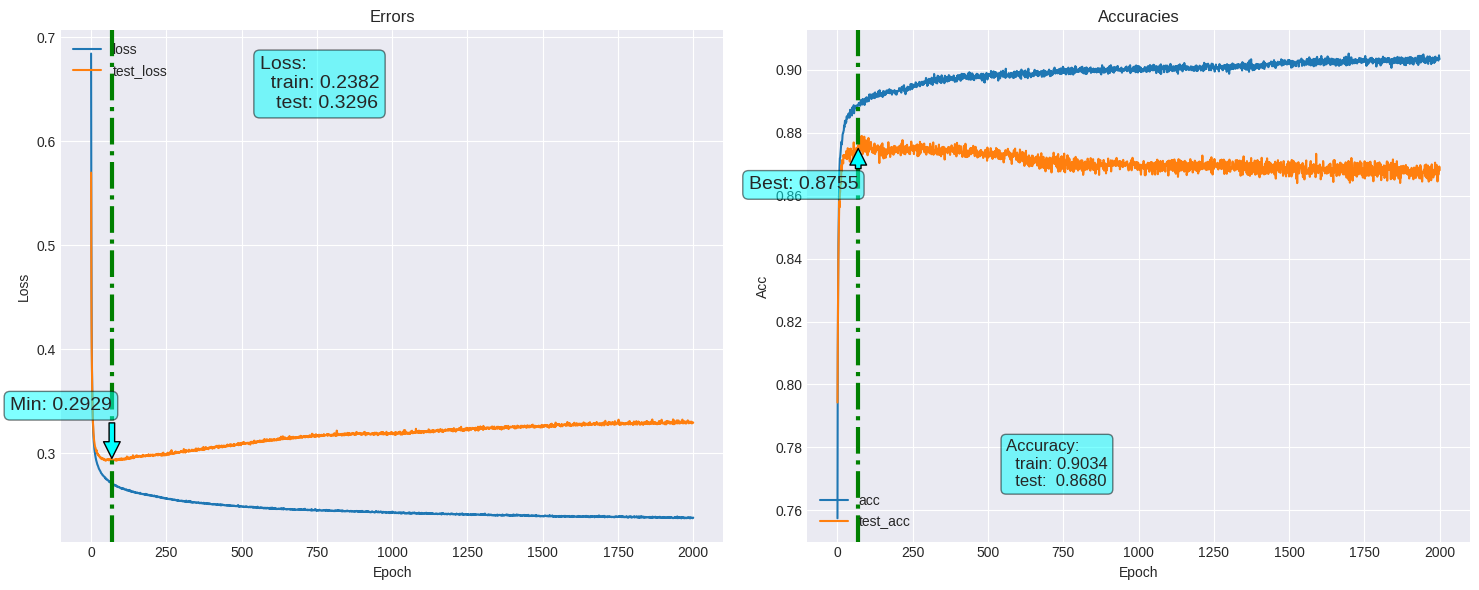

In [ ]:
fn_plot_torch_hist(loss_df)

In [ ]:
outputs = model(x_train_tensor)
y_pred = torch.argmax(outputs, dim = 1).cpu().detach().numpy()

NameError: name 'x_train_tensor' is not defined

In [ ]:
y_true = y_train_tensor.cpu().numpy()
print(classification_report(y_true, y_pred))

NameError: name 'y_train_tensor' is not defined

In [ ]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels = class_labels.values())
disp.plot(cmap = 'Blues', xticks_rotation = 'vertical', colorbar = False)
plt.grid(False)

Performance of model on Test Dataset

In [ ]:
outputs = model(x_test_tensor)
y_pred = torch.argmax(outputs, dim = 1).cpu().detach().numpy()

In [ ]:
y_true = y_test_tensor.cpu().numpy()
print(classification_report(y_true, y_pred))

In [ ]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels = class_labels.values())
disp.plot(cmap = 'Blues', xticks_rotation = 'vertical', colorbar = False)
plt.grid(False)